In [2]:
import numpy as np
from scipy.stats import norm
import copy
import matplotlib.pyplot as plt
from __future__ import division

In [ ]:
class agent_based_model:
    
    """set the model as object"""
    
    # constructor
    def __init__(self, v=1 , N_regions=42, dt=0.01, sconn_len=None, sconn_den=None, snca=None, gba=None, roi_size=None, fconn=None, fcscale=None):
        
        # number of regions
        self.N_regions = N_regions
        
        # store number of normal and misfolded proteins in regions
        self.nor = np.zeros((N_regions,), dtype = np.int)
        self.nor_history = np.empty((0, N_regions), dtype = np.int)
        self.mis = np.zeros((N_regions,), dtype = np.int)
        self.mis_history = np.empty((0, N_regions), dtype = np.int)
        
        
        # store number of normal and misfolded proteins in paths
        self.sconn_len = np.int_(np.round(sconn_len / v))
        (self.idx_x, self.idx_y) = np.nonzero(self.sconn_len)
        self.non_zero_lengths = self.sconn_len[self.idx_x, self.idx_y]  # int64
        self.path_nor, self.path_mis = [ [ [[] for y in range(N_regions)] for x in range(N_regions)] ] * 2
        
        #### is there more efficient way to do this?  --- to be updated.......
        for x, y, v in zip(self.idx_x, self.idx_y, self.non_zero_lengths):
            self.path_nor[x][y], self.path_mis[x][y] = [ [0 for k in range(v)] ] * 2
            
        # record the trajectory
        self.path_nor_history = []
        self.path_mis_history = []
        
        # continuous path and path history
        self.path_nor_cont, self.path_mis_cont = [np.zeros((N_regions, N_regions), dtype = np.int)] * 2
        self.path_nor_cont_history, self.path_mis_cont_history = [np.empty((0, self.N_regions, self.N_regions))] * 2
        
        # time step
        self.dt = dt
        
        # synthesis rate and clearance rate
        self.synthesis_rate = norm.cdf(snca) * self.dt
        self.clearance_rate = 1 - np.exp(-norm.cdf(gba) * self.dt)       
        
        # probability of exit a path is set to v/sconn_len
        sconn_len[sconn_len ==0] = np.inf
        self.prob_exit = self.dt * v / sconn_len
        self.prob_exit[sconn_len==0] = 0 # remove NaNs....
        
        # travel weights
        self.weights = np.exp(fcscale * fconn) * sconn_den
        
        self.weights = np.sum(self.weights, axis = 1) * np.eye(self.N_regions) + self.weights
        
        # scale 
        self.weights = self.weights / np.sum(self.weights, axis = 1).reshape(self.N_regions, 1)
        
        self.weights_euler = self.weights * self.dt
        self.weights_euler[np.eye(self.N_regions)==1] = 0
        self.weights_euler[np.eye(self.N_regions)==1] = 1-np.sum(self.weights_euler, axis=1)
        
        # region size
        self.roi_size = roi_size.flatten()
        
        self.synthesis_control = np.int_(roi_size.flatten())
        
                
    def normal_alpha_syn_growth_region(self):
        """step: normal alpha-syn synthesized and cleared in regions"""

        self.nor -= np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                             for k, v in zip(self.clearance_rate, self.nor)])
        
        
        ## synthesis
        self.nor += np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                              for k, v in zip(self.synthesis_rate, self.synthesis_control) ])
                              # or self.roi_size)])
    
    def normal_alpha_syn_growth_edge_discrete(self):
        """proteins are moving discretely in edges"""
        # alpha syn  -- from region to path
        # exit region
        exit_process = np.array([ np.random.multinomial(self.nor[k], self.weights[k]) 
                                 for k in range(self.N_regions)], dtype = np.int)
        
        # alpha syn -- from path to region
        # enter region
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype=np.int)
        
        for x, y in zip(self.idx_x, self.idx_y):
            # fetch then remove the last element
            enter_process[x, y] = self.path_nor[x][y].pop()
            # update paths
            self.path_nor[x][y].insert(0, exit_process[x, y])

        # update regions 
        self.nor = exit_process[np.nonzero(np.eye(self.N_regions))] + np.sum(enter_process, axis = 0)
        
    def normal_alpha_syn_growth_edge(self):
        """proteins are moving contiously in edges"""
        
        # exit regions:
        exit_process = np.array([ np.random.multinomial(self.nor[k], self.weights_euler[k]) 
                                 for k in range(self.N_regions)], dtype = np.int) 
        exit_process[np.eye(self.N_regions)==1] = 0 # remove diag
        
        # enter regions:
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype = np.int)
        
        for x, y in zip(self.idx_x, self.idx_y):
            enter_process[x, y] = np.sum(np.random.uniform(0, 1, (self.path_nor_cont[x, y], )) < self.prob_exit[x, y]*self.dt)
        
        # update:
        self.path_nor_cont += (exit_process - enter_process)        
        self.nor += (np.sum(enter_process, axis = 0) - np.sum(exit_process, axis=1) )
        
        
    def inject_mis(self, seed=42, initial_number=1):
        
        """inject initual_number misfolded protein into seed region"""
        # initial_number must be an interger
        self.mis[seed] = initial_number
        #print('inject %d misfolded alpha-syn into region %d' % (initial_number, seed))
        
    
    def misfolded_alpha_syn_spread_edge_discrete(self):
        """ step in paths for normal and misfolded alpha syn"""
        
        ############## misfolded alpha synuclein ###########
        # exit regions
        exit_process = np.array([ np.random.multinomial(v, self.weights[k]) 
                                 for k, v in enumerate(self.mis)], dtype = np.int)
        # alpha syn -- from path to region
        # enter region
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype = np.int)
        for x, y in zip(self.idx_x, self.idx_y):
            # fetch then remove the last element
            enter_process[x, y] = self.path_mis[x][y].pop()
            # update paths
            self.path_mis[x][y].insert(0, exit_process[x, y])

        # update regions 
        self.mis = exit_process[np.nonzero(np.eye(self.N_regions))] + np.sum(enter_process, axis = 0)
        
        ########### for the normal alpha syuclein ###########
        exit_process = np.array([ np.random.multinomial(self.nor[k], self.weights[k]) 
                                 for k in range(self.N_regions)], dtype = np.int)
        
        # alpha syn -- from path to region
        # enter region
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype=np.int)
        
        for x, y in zip(self.idx_x, self.idx_y):
            # fetch then remove the last element
            enter_process[x, y] = self.path_nor[x][y].pop()
            # update paths
            self.path_nor[x][y].insert(0, exit_process[x, y])

        # update regions 
        self.nor = exit_process[np.nonzero(np.eye(self.N_regions))] + np.sum(enter_process, axis = 0)
        
    def misfolded_alpha_syn_spread_edge(self):
        """proteins are moving continously"""
        ##### misfolded alpha synuclein #####
        exit_process = np.array([ np.random.multinomial(v, self.weights_euler[k]) 
                                 for k, v in enumerate(self.mis)], dtype = np.int) 
        exit_process[np.eye(self.N_regions)==1] = 0
        
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype = np.int)
        # enter regions:
        for x, y in zip(self.idx_x, self.idx_y):
            enter_process[x, y] = np.sum(np.random.uniform(0, 1, (self.path_mis_cont[x, y], ))< self.prob_exit[x, y] * self.dt)
        
        # update
        self.path_mis_cont += (exit_process - enter_process)
        self.mis +=  (np.sum(enter_process, axis = 0) - np.sum(exit_process, axis = 1) )
        
        ####### normal alpha synuclein #######
        # exit regions:
        exit_process = np.array([ np.random.multinomial(self.nor[k], self.weights_euler[k]) 
                                 for k in range(self.N_regions)], dtype = np.int) * self.dt
        exit_process[np.eye(self.N_regions)==1] = 0
        
        # enter regions:
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype = np.int)
        for x, y in zip(self.idx_x, self.idx_y):
            enter_process[x, y] = np.sum(np.random.uniform(0, 1, (self.path_nor_cont[x, y], ) ) < self.prob_exit[x, y]*self.dt)
            
        # update:
        self.path_nor_cont += (exit_process - enter_process)
        self.nor += (np.sum(enter_process, axis = 0) - np.sum(exit_process, axis=1) )
        
    def misfolded_alpha_syn_spread_region(self, trans_rate=1):
        """clearance and synthesis of normal/misfolded alpha-syn/ transsmssion process in regions"""
        ## clearance
        cleared_nor = np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                             for k, v in zip(self.clearance_rate, self.nor)])
        
        cleared_mis = np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                             for k, v in zip(self.clearance_rate, self.mis)])
        
        self.prob_infected = 1 - np.exp(- (self.dt * self.mis * trans_rate / (self.roi_size)) )
        # the remaining after clearance
        self.nor -= cleared_nor
        self.mis -= cleared_mis
        #self.prob_infected = 1 - np.exp(- (self.mis / self.roi_size) )
        infected_nor = np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                             for k, v in zip(self.prob_infected, self.nor)])
        # update self.nor and self.mis
        self.nor += (np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                              for k, v in zip(self.synthesis_rate, self.roi_size)]) - infected_nor)
        self.mis += infected_nor 
        
        #print(self.mis)
        
    def transmission_path(self, trans_rate_path):
        
        """transmission process in path (default shut down)"""
        for x, y, v in zip(self.idx_x, self.idx_y, self.non_zero_lengths):
            ### perhaps trans_rate_path should be set to 1/v ?
            # transmission rate is scaled by exp(distance) in voxel space
            path_nor_temp = np.array(self.path_nor[x][y])
            path_mis_temp = np.array(self.path_mis[x][y])
            rate_get_infected = (path_mis_temp * trans_rate_path) / np.exp(np.absolute(np.arange(v) - np.arange(v)[np.newaxis].T) )
            prob_get_infected = 1 - np.exp(np.sum(-rate_get_infected, axis = 1))
            infected_path = np.array([np.sum(np.random.uniform(0, 1, (k, ))<v) for 
                                      k, v in zip(self.path_nor[x][y], prob_get_infected)])
            
            # update self.path_nor and self.path_mis
            path_nor_temp -= infected_path
            path_mis_temp += infected_path
            
            self.path_nor[x][y] = path_nor_temp.tolist()
            self.path_mis[x][y] = path_mis_temp.tolist()
            
        
    def record_to_history_discrete(self):
        """record the results of each step into the recorder"""
        self.nor_history = np.append(self.nor_history, self.nor[np.newaxis], axis = 0)
        self.mis_history = np.append(self.mis_history, self.mis[np.newaxis], axis = 0)
        
        # record the mobility patterns in edges
        #self.path_nor_history.append(self.path_nor)
        #self.path_mis_history.append(self.path_mis)
        
    def record_to_history_continous(self):
        """record the results of each step"""
        self.nor_history = np.append(self.nor_history, self.nor[np.newaxis], axis = 0)
        self.mis_history = np.append(self.mis_history, self.mis[np.newaxis], axis = 0)
        
        # record the mobility patterns in edges
        #self.path_nor_cont_history = np.append(self.path_nor_cont_history, self.path_nor_cont.reshape(1, 42, 42), axis = 0)
        #self.path_mis_cont_history = np.append(self.path_mis_cont_history, self.path_mis_cont.reshape(1, 42, 42), axis = 0)
        

In [ ]:
class SIR_model:
    """An SIR model to simulate the spread of alpha-syn"""
    
    # constructor
    def __init__(self, v=1 , N_regions=42, dt=0.01, sconn_len=None, sconn_den=None, snca=None, gba=None, roi_size=None, fconn=None, fcscale=None):
        
        # number of regions
        self.N_regions = N_regions
        
        # store number of normal and misfolded proteins in regions
        self.nor = np.zeros((N_regions, ))
        self.mis = np.zeros((N_regions, ))
        self.nor_history = np.empty((0, N_regions))
        self.mis_history = np.empty((0, N_regions))
        
        # store number of normal and misfoded proteins in paths
        self.path_nor = np.zeros((N_regions, N_regions))
        self.path_mis = np.zeros((N_regions, N_regions))
        self.path_nor_history = np.empty((0, N_regions, N_regions))
        self.path_mis_history = np.empty((0, N_regions, N_regions))
        
        # index of connected components
        (self.idx_x, self.idx_y) = np.nonzero(sconn_len)
        self.non_zero_lengths = sconn_len[np.nonzero(sconn_len)]
        
        # probability of exit a path is set to v/sconn_len
        #sconn_len2 = sconn_len.copy()
        sconn_len[sconn_len == 0] = np.inf
        self.prob_exit = v / sconn_len
        self.prob_exit[sconn_len==0] = 0
        
        # synthesis rate and  clearance rate
        self.synthesis_rate = norm.cdf(snca) * self.dt
        self.clearance_rate = 1 - np.exp( -norm.cdf(gba) * self.dt)
        
        # mobility pattern multinomial distribution
        self.weights = np.exp(fcscale * fconn) * sconn_den
        self.weights = np.diag(np.sum(sconn_den, axis = 1)) + sconn_den
        self.weights = self.weights / np.sum(self.weights, axis = 1)[np.newaxis].T
        
        # region size
        self.roi_size = roi_size.flatten() 
        
    def normal_alpha_syn_growth_region(self):
        """normal alpha-syn growing"""
        self.nor += (self.roi_size * self.synthesis_rate - self.nor * self.clearance_rate)
        
    def normal_alpha_syn_growth_edge(self):
        
        # enter paths
        enter_process = self.nor.reshape(self.N_regions, 1) * self.weights * self.dt
        enter_process[np.eye(self.N_regions)==1] = 0 # remove diag
        
        # exit paths
        exit_process = self.path_nor * self.prob_exit * self.dt
        
        # update paths and regions  
        self.nor += (np.sum(exit_process, axis = 0) - np.sum(enter_process, axis = 1) )
        self.path_nor += (enter_process - exit_process)        
        
    def inject_mis(self, seed=41, initial_number=1):
        """inject misfolded alpha-syn in seed region"""
        
        self.mis[seed] = initial_number
        #print('inject %d misfolded alpha-syn into region %d' % (initial_number, seed))
        
    def misfolded_alpha_syn_spread_edge(self):
        ##### misfolded alpha-syn
        # enter paths
        enter_process = self.mis.reshape(self.N_regions, 1) * self.weights * self.dt
        enter_process[np.eye(self.N_regions)==1] = 0 # remove diag
        
        # exit paths
        exit_process = self.path_mis * self.prob_exit
        
        # update paths and regions 
        self.mis += (-np.sum(enter_process, axis=1) + np.sum(exit_process, axis = 0))
        self.path_mis += (enter_process - exit_process)
        
        ###### normal alpha-syn
        # enter paths
        enter_process = self.nor.reshape(self.N_regions, 1) * self.weights * self.dt
        enter_process[np.eye(self.N_regions)==1] = 0 # remove diag
        
        # exit paths
        exit_process = self.path_nor * self.prob_exit * self.dt
        
        # update paths and regions  
        self.nor += (np.sum(exit_process, axis = 0) - np.sum(enter_process, axis = 1) )
        self.path_nor += (enter_process - exit_process)
        
    def misfolded_alpha_syn_spread_region(self, trans_rate=1):
        '"""the transmission process inside regions"""'
        
        prob_get_infected = 1 - np.exp(-self.mis * trans_rate * self.dt / self.roi_size)
        # clear process
        self.nor -= self.nor * self.clearance_rate
        self.mis -= self.mis * self.clearance_rate
        
        infected = self.nor * prob_get_infected
        self.nor += (self.roi_size * self.synthesis_rate - infected)
        self.mis += (infected)
        
    def transmission_path(self):
        
        """the transmission process in paths""" 
        pass
    
    def record_to_history(self):
        """record the results"""
        self.nor_history = np.append(self.nor_history, self.nor[np.newaxis], axis = 0)
        self.mis_history = np.append(self.mis_history, self.mis[np.newaxis], axis = 0)
        
        self.path_nor_history = np.append(self.path_nor_history, 
                                          self.path_nor.reshape(1, self.N_regions, self.N_regions), axis = 0)
        self.path_mis_history = np.append(self.path_mis_history, 
                                          self.path_mis.reshape(1, self.N_regions, self.N_regions), axis = 0)
        
        

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats.stats import zscore,pearsonr

In [61]:
para = loadmat('/Users/yingqiuzheng/Desktop/Research/PD/Lh/DTIseeds/Resol1/parameters_final_normalized.mat')

In [62]:
sconn_len = np.array(para['sc_len_total'])
sconn_den = np.array(para['sc_ncount_n_total'])
roi_size = np.array(para['ROIsize'])
gba = para['GBA']
snca = para['SNCA']
real_atrophy = para['real_atrophy']

In [63]:
ref_model = agent_based_model(v=1 , N_regions=42, dt=0.01, sconn_len=sconn_len, sconn_den=sconn_den, snca=snca.flatten(), gba=gba.flatten(), roi_size=roi_size.flatten(), fconn=np.zeros((42, 42)), fcscale=0)

In [65]:
for t in range(10000):
    ref_model.record_to_history_continous()
    ref_model.normal_alpha_syn_growth_edge_continuous()
    ref_model.normal_alpha_syn_growth_region()
    print(ref_model.nor)    

[ 7682  4857  2783  5198  5175  5887 16196 21399  7688 12522  4378  3430
  2770  4571  4076 10303 13225 14802 15725  9916  7372  9737 10985  9290
 10539  3716  3312  3569 12183 14465  8838 16176  4443  8924  1193  4474
  6911  2153  2522  4405  5355  1100]
[ 7697  4850  2781  5212  5165  5866 16189 21369  7700 12499  4383  3428
  2770  4573  4070 10318 13235 14805 15727  9907  7354  9736 10978  9279
 10588  3725  3308  3564 12206 14475  8830 16175  4431  8924  1192  4491
  6921  2158  2530  4414  5365  1098]
[ 7680  4841  2787  5204  5159  5851 16195 21369  7706 12518  4387  3421
  2753  4583  4071 10316 13224 14813 15733  9906  7350  9724 10984  9272
 10578  3729  3298  3565 12184 14486  8827 16169  4437  8936  1179  4496
  6907  2152  2529  4404  5373  1097]
[ 7669  4841  2791  5189  5149  5873 16207 21347  7695 12524  4375  3422
  2736  4596  4080 10314 13232 14817 15721  9910  7354  9723 11021  9268
 10589  3720  3305  3560 12208 14509  8847 16165  4437  8943  1176  4481
  6907  21

[ 7609  4843  2825  5260  5013  5874 16177 21370  7569 12486  4389  3403
  2759  4567  4114 10361 13283 14826 15545  9964  7437  9770 11157  9319
 10561  3781  3394  3470 12170 14395  8871 16226  4452  9063  1187  4510
  6925  2177  2502  4379  5406  1107]
[ 7601  4856  2810  5273  5015  5874 16191 21369  7569 12458  4408  3381
  2750  4569  4125 10360 13260 14833 15561  9963  7425  9761 11147  9313
 10586  3759  3408  3476 12180 14384  8889 16207  4449  9077  1187  4515
  6949  2185  2500  4382  5394  1101]
[ 7569  4852  2796  5289  5005  5877 16185 21347  7568 12471  4412  3370
  2740  4571  4128 10376 13253 14845 15560  9975  7423  9760 11136  9288
 10581  3760  3391  3457 12156 14381  8877 16238  4459  9088  1191  4521
  6949  2179  2493  4380  5381  1097]
[ 7574  4860  2796  5282  4967  5866 16239 21293  7571 12454  4395  3363
  2730  4587  4120 10381 13264 14851 15579  9979  7419  9782 11150  9301
 10610  3759  3395  3463 12168 14398  8891 16228  4465  9084  1202  4526
  6958  21

[ 7676  4883  2782  5291  4958  5814 16184 21354  7567 12428  4399  3409
  2754  4549  4134 10401 13089 14820 15626  9923  7581  9858 11003  9239
 10808  3751  3390  3471 12301 14268  8890 16163  4495  9073  1203  4547
  7035  2179  2487  4271  5375  1101]
[ 7680  4887  2775  5288  4980  5811 16218 21349  7573 12454  4408  3407
  2756  4564  4144 10433 13109 14852 15613  9925  7581  9856 11006  9223
 10798  3763  3392  3464 12301 14274  8916 16167  4503  9063  1199  4548
  7037  2175  2492  4270  5379  1112]
[ 7656  4886  2779  5285  4973  5831 16220 21345  7580 12439  4407  3382
  2761  4571  4147 10447 13094 14866 15640  9914  7585  9853 11000  9241
 10805  3771  3399  3459 12305 14284  8903 16179  4516  9067  1196  4552
  7042  2182  2497  4272  5379  1118]
[ 7656  4884  2785  5288  4979  5827 16232 21303  7560 12451  4422  3393
  2762  4554  4155 10449 13102 14864 15647  9914  7578  9847 10991  9256
 10804  3773  3406  3460 12322 14286  8893 16154  4524  9081  1192  4553
  7030  21

[ 7643  4921  2829  5221  5047  5904 16343 21211  7609 12530  4464  3428
  2726  4560  4159 10460 13145 14781 15749  9898  7527  9917 11099  9206
 10712  3753  3453  3521 12290 14319  8833 16187  4504  9060  1231  4570
  7028  2134  2554  4270  5406  1126]
[ 7639  4919  2817  5219  5053  5887 16351 21207  7609 12544  4457  3436
  2720  4568  4174 10441 13163 14782 15745  9898  7537  9897 11095  9194
 10705  3754  3450  3521 12286 14334  8841 16175  4507  9043  1232  4582
  7033  2142  2551  4259  5406  1112]
[ 7641  4911  2810  5220  5054  5888 16341 21183  7618 12570  4471  3436
  2717  4566  4162 10461 13165 14772 15776  9892  7536  9907 11085  9202
 10685  3757  3465  3508 12276 14299  8845 16156  4520  9037  1233  4584
  7037  2141  2558  4247  5395  1113]
[ 7639  4901  2794  5236  5053  5861 16348 21191  7629 12598  4473  3446
  2720  4583  4158 10439 13155 14751 15741  9889  7566  9917 11090  9208
 10663  3757  3473  3516 12242 14303  8865 16156  4508  9066  1230  4576
  7037  21

[ 7516  4961  2801  5250  5131  5920 16219 21122  7667 12560  4409  3363
  2688  4588  4169 10261 13208 14811 15700  9941  7614  9887 11054  9138
 10646  3800  3416  3456 12180 14338  8847 16310  4558  8933  1190  4593
  7028  2153  2599  4317  5418  1107]
[ 7521  4959  2811  5251  5139  5924 16217 21138  7673 12564  4417  3359
  2672  4568  4175 10260 13216 14827 15714  9934  7604  9880 11035  9133
 10639  3789  3423  3451 12176 14310  8856 16320  4556  8947  1190  4592
  7027  2160  2601  4311  5415  1107]
[ 7523  4960  2809  5250  5134  5916 16207 21139  7675 12569  4404  3346
  2667  4584  4180 10259 13223 14837 15704  9933  7606  9902 11032  9140
 10625  3787  3420  3442 12145 14305  8863 16309  4548  8947  1190  4596
  7031  2164  2594  4302  5410  1111]
[ 7511  4956  2801  5229  5132  5899 16192 21152  7671 12570  4410  3363
  2668  4575  4168 10239 13231 14810 15689  9932  7616  9900 11038  9141
 10646  3782  3446  3426 12138 14308  8847 16299  4549  8970  1189  4599
  7037  21

KeyboardInterrupt: 

/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


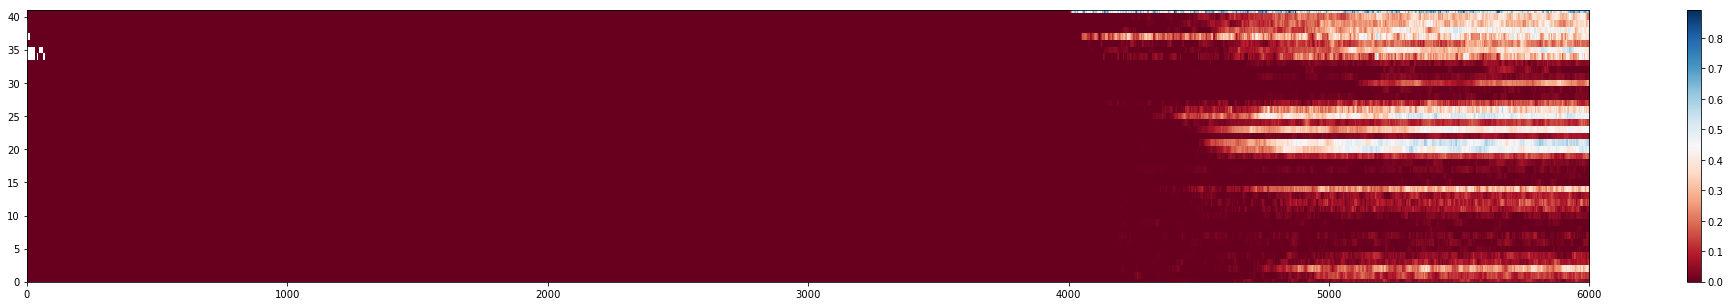

In [380]:
ratio = one_model.mis_history / (one_model.mis_history + one_model.nor_history)
plt.figure(figsize = (35, 5))
plt.imshow(ratio.T,  cmap=plt.cm.RdBu, aspect='auto')
plt.xlim(0, 6000)
plt.ylim(0, 41)
plt.colorbar()
plt.show()

In [41]:
snca

array([[ 0.59934275],
       [ 0.26101632],
       [ 0.29000476],
       [ 0.82548406],
       [ 0.64681165],
       [ 0.46708861],
       [ 0.39060002],
       [ 0.540445  ],
       [ 0.23598362],
       [ 0.07745063],
       [ 0.16678801],
       [ 1.09441929],
       [ 0.5493068 ],
       [ 0.61300713],
       [ 0.39203754],
       [ 0.12267327],
       [ 0.47482925],
       [ 0.11458936],
       [ 0.33640297],
       [ 0.07466711],
       [-0.37034188],
       [-0.94981583],
       [-0.19041772],
       [-0.30001395],
       [ 0.74709943],
       [ 0.44602376],
       [ 0.43051001],
       [ 0.75563896],
       [ 0.62976586],
       [ 0.65549983],
       [ 0.36909722],
       [ 0.64775809],
       [ 0.28991633],
       [ 0.77699072],
       [-3.33599077],
       [-2.04487788],
       [-2.00433353],
       [-2.77105086],
       [-1.67836188],
       [-0.47255766],
       [-0.79877398],
       [ 0.89528759]])

In [28]:
print(ref_model.weights[:, 0])

[  5.00000000e-01   1.09868721e-01   0.00000000e+00   0.00000000e+00
   3.36497591e-02   0.00000000e+00   1.95975993e-02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.36619557e-03   0.00000000e+00   3.11679657e-04
   4.11281586e-04   6.01634015e-03   9.77070167e-03   7.71687431e-03
   1.31527236e-03   0.00000000e+00   1.53863229e-03   2.12806671e-02
   0.00000000e+00   0.00000000e+00   0.00000000e+00   2.85076141e-02
   0.00000000e+00   4.01616247e-02   2.05182233e-03   1.54469524e-02
   1.85345943e-02   0.00000000e+00   4.74075350e-03   0.00000000e+00
   3.45647835e-03   0.00000000e+00]


In [615]:
for t in range(600):
    ref_model.record_to_history()
    ref_model.nor_step_region()
    ref_model.nor_travel()

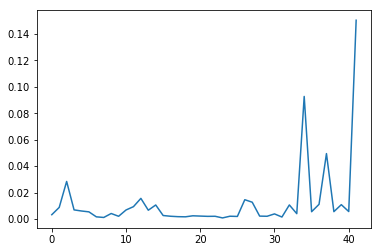

0.17210000123132613

In [681]:
plt.plot(np.arange(42), (1  - np.exp(- 7 / ref_model.nor)  ) )
#plt.plot(np.arange(42), ref_model.clearance_rate)
plt.show()
#np.max((1  - np.exp(- 1 / roi_size.flatten())  )* ref_model.nor*ref_model.clearance_rate)

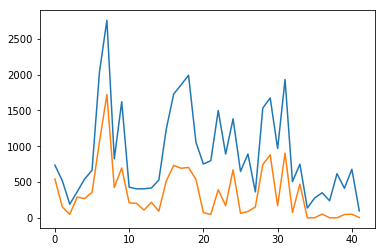

In [264]:
plt.plot(np.arange(42), ref_model.nor_history[599,:])
plt.plot(np.arange(42), ref_model.synthesis_rate * ref_model.roi_size)
plt.show()

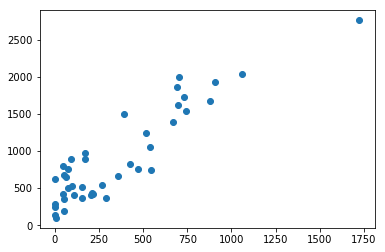

In [267]:
plt.plot(ref_model.synthesis_rate * ref_model.roi_size, ref_model.nor_history[599,:], marker = 'o', ls='')
plt.show()

In [36]:
print(norm.cdf(snca)/norm.cdf(gba))

[[  1.15690787e+00]
 [  1.14086174e+00]
 [  1.04870543e+00]
 [  1.02317342e+00]
 [  1.08578554e+00]
 [  8.76823156e-01]
 [  1.03842504e+00]
 [  8.90289158e-01]
 [  8.24914831e-01]
 [  1.11276006e+00]
 [  1.10043645e+00]
 [  1.01179406e+00]
 [  7.98874928e-01]
 [  1.29209067e+00]
 [  8.29381671e-01]
 [  1.21210413e+00]
 [  1.30687472e+00]
 [  1.38135591e+00]
 [  1.63923477e+00]
 [  1.29877197e+00]
 [  3.42789499e+00]
 [  3.68423636e+00]
 [  1.70766039e+00]
 [  8.72928303e+01]
 [  1.58000031e+00]
 [  1.26533207e+01]
 [  8.43128091e-01]
 [  9.16965475e-01]
 [  1.21504867e+00]
 [  1.08199065e+00]
 [  2.29606920e+00]
 [  1.64092023e+00]
 [  1.04559176e+00]
 [  1.02064491e+00]
 [  9.98085575e-04]
 [  3.50647031e-01]
 [  2.92358202e-01]
 [  2.47413856e-02]
 [  2.96755626e-01]
 [  4.20820030e-01]
 [  1.84835973e+00]
 [  5.17483578e-01]]


In [143]:
ref_model.nor

array([ 879,  694,  416,  632,  823,  992, 1765, 1886, 1139, 1474,  678,
        668,  701,  742,  802, 1443, 1949, 1670, 2181, 1027,  791,  937,
       1642, 1066, 1427,  865,  937,  705, 1806, 1835, 1568, 1669,  974,
       1014,  560,  791,  877,  612,  779,  816,  856,  331])

In [415]:
one_model.prob_infected

array([ 0.06729488,  0.35529803,  0.73324605,  0.12097314,  0.10151572,
        0.0747023 ,  0.00809712,  0.00237094,  0.00564572,  0.0325992 ,
        0.05016841,  0.21395461,  0.33173931,  0.1171316 ,  0.54338196,
        0.06897323,  0.08649545,  0.13763325,  0.27509847,  0.08605413,
        0.61562643,  0.78802396,  0.30775552,  0.41351404,  0.12158858,
        0.78483114,  0.91990887,  0.38547827,  0.05023546,  0.03751977,
        0.73245257,  0.14613648,  0.61959819,  0.05754343,  0.04443696,
        0.19889937,  0.12269019,  0.33397811,  0.79225181,  0.25627427,
        0.63212056,  0.96491565])

In [30]:
from scipy.io import loadmat
para2 = loadmat('/dagher/dagher6/yzheng/ICBM152_nlin_sym_09a/simulator_v3/workspace.mat')
nsconn_den = para2['nsconnDen_th']
np.sum(nsconn_den, axis = 1).shape
weights = nsconn_den / np.sum(nsconn_den, axis = 0)[np.newaxis]
print(np.sum(weights, axis = 0))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.]


/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


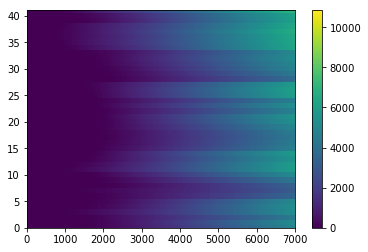

In [719]:
ratio = one_model.mis_history / (one_model.mis_history + one_model.nor_history)
plt.imshow(ratio_cum.T, aspect='auto')
plt.xlim(0, 7000)
plt.ylim(0, 41)
plt.colorbar()
plt.show()

In [718]:
weights = nsconn_den / np.sum(nsconn_den, axis = 0)[np.newaxis]
ratio_th = ratio.copy()
ratio_th[ratio<0] = 0
ratio_cum = np.dot( (1 - np.exp(-ratio_th)), weights)
ratio_cum = ratio_cum + 1-np.exp(-ratio_th)
ratio_cum = np.cumsum(ratio_cum[3000:], axis = 0)
(r, p) = pearsonr(ratio[-1, :-1], real_atrophy.flatten())
r

/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


0.33226946305995808

In [325]:
plt.plot

array([[ 1.        ,  0.47877552],
       [ 0.47877552,  1.        ]])

In [326]:
r

0.48432958286706079

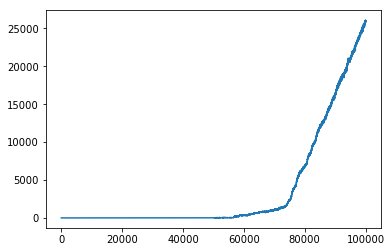

In [762]:
plt.plot(np.arange(one_model.mis_history.shape[0]), one_model.mis_history[:, 41])
plt.show()

In [149]:
ref_model.nor

array([ 98,  81,  50,  63,  84,  96, 166, 202,  93, 140,  76,  64,  66,
        80,  76, 149, 186, 173, 198,  98,  86, 112, 169, 118, 148,  73,
        98,  72, 186, 181, 161, 209,  95,  98,  63,  77,  91,  76,  74,
        74,  84,  78])

In [168]:
np.nonzero(sconn_len[41])

(array([ 4,  6,  7,  9, 34, 35, 36, 37]),)

In [169]:
sconn_len[41, np.nonzero(sconn_len[41])]

array([[ 165.14837153,  168.49995681,  167.82605699,  151.36596958,
          17.91637478,   74.84649271,   72.02182617,   32.24336325]])

In [273]:
r = np.zeros((42, 100))
for region in np.arange(42):
    """iterate through regions to find epicentre"""
    for simulation in np.arange(100):
        one_model = copy.deepcopy(ref_model)
        one_model.inject_mis(41, 1)
        for t in range(2000):
            one_model.record_to_history()
            one_model.transmission_region()
            one_model.nor_travel()
            one_model.mis_travel()
        
        ratio = one_model.mis_history / (one_model.mis_history + one_model.nor_history)
        ratio_th = ratio.copy()
        ratio_th[ratio<0.2] = 0
        ratio_cum = np.dot( (1 - np.exp(-ratio_th)), weights)
        ratio_cum = ratio_cum + 1-np.exp(-ratio_th)
        ratio_cum = np.cumsum(ratio_cum[600:], axis = 0)
        (r[region, simulation], p) = pearsonr(ratio_cum[-1, :-1], real_atrophy.flatten())
        if r[region,simulation] == np.nan:
            r[region, simulation] = 0

/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less
/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [281]:
r[np.isnan(r)] = 0

In [283]:
mean_r = np.mean(r, axis = 1)

In [298]:
sconn = loadmat('/dagher/dagher6/yzheng/ICBM152_nlin_sym_09a/sconn0712.mat')
sconn_len = sconn['sconnLen_expand']
sconn_den = sconn['sconnDen_expand']

In [45]:
print(one_model.mis_history[:, 41])

[   0    0    0 ..., 3082 3053 3070]


In [99]:
print(ref_model.synthesis_rate * roi_size.flatten())

[  8.71045629e+01   2.44279151e+01   8.07609215e+00   4.67646055e+01
   4.31845838e+01   5.71520132e+01   1.69668704e+02   2.75811527e+02
   6.80735200e+01   1.11660786e+02   3.36038559e+01   3.25342214e+01
   1.75935082e+01   3.48760295e+01   1.51401900e+01   8.25698423e+01
   1.17402206e+02   1.10985553e+02   1.12762813e+02   8.58580759e+01
   1.18964971e+01   7.71937333e+00   6.30244032e+01   2.75063723e+01
   1.07455136e+02   1.03872478e+01   1.44369335e+01   2.45134048e+01
   1.19056923e+02   1.40863963e+02   2.71009788e+01   1.45001612e+02
   1.20936880e+01   7.54361074e+01   6.59048287e-02   4.97597493e-01
   8.62870038e+00   3.75899533e-01   2.40217690e-01   7.66946222e+00
   8.40637415e+00   8.08588838e-01]


In [122]:
np.ones((3, ), dtype = np.int) * 0.01

array([ 0.01,  0.01,  0.01])

In [124]:
np.array([k for k in range(4)]) * 0.1

array([ 0. ,  0.1,  0.2,  0.3])